#Training a Neural Network in PyTorch#

PyTorch is a powerful, widely-used machine learning library. It has all the latest neural network layers and functions and supports GPU computation.

Most neural network research these days either happens in PyTorch or TensorFlow. Google Research develops TensorFlow while Facebook AI Research develops PyTorch. Functionally they are probably very similar, I just know a lot of people who use PyTorch and it seems like it might be somewhat easier for beginners to learn. It is important to have some experience in one of these two frameworks but if you understand the ideas and concepts you shouldn't have too much trouble moving between them.

The `torch` library provides the basic functions we need when dealing with `tensors`. `tensors` are a generalization of matrices to arbirtrary numbers of dimensions (a matrix is a 2D tensor). Types of tensors:


*   0 dimensional: Scalar
*   1 dimensional: Array
*   2 dimensional: Matrix
*   3 dimensional: Number cubey thingy
*   4 dimensional: ?????

Anywho, let's start with our opening chant to invoke the power of PyTorch to aid us. The last line is a special call to the GPU gods to smile on our endeavor.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import seaborn as sns
sns.set_theme()

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0")

##Time For Some Data##

PyTorch has some built tools for downloading and loading common datasets. We'll be playing around with MNIST in this example. It is a dataset of 28x28 grayscale handwritten digits 0-9. There are 50,000 images in the training set and 10,000 in the test set.



In [2]:
def get_mnist_data():
  trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                        transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,
                                            num_workers=8)

  testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                      transform=transforms.ToTensor())
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False,
                                          num_workers=8)
  classes = range(10)
  return {'train': trainloader, 'test': testloader, 'classes': classes}

data = get_mnist_data()

###Understanding Our Data ###
It's worthwhile to check out how our dataloader loads the images into tensors. We can print out the size of the loaded data in the `images` tensors.



In [3]:
# get some random training images
dataiter = iter(data['train'])
images, labels = dataiter.next()
print(images.size())

torch.Size([32, 1, 28, 28])


Our `images` tensor is 4-dimensional, (32 x 1 x 28 x 28)

PyTorch stores image data in (N x C x H x W) format. Thus the size of this tensor implies we have a mini-batch of 32 images, each have a single channel (grayscale), and each image is 28 x 28, so that makes sense!

We can use matplotlib to see what our data looks like:

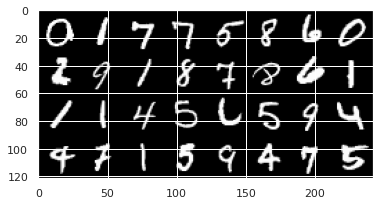

        0         1         7         7


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % data['classes'][labels[j]] for j in range(4)))


##A Simple Network##

First we'll build a very basic neural network with a single hidden layer of neurons. This means one fully connected layer of weights connects the input to the hidden neurons and one fully connected layer connects the hidden neurons to the output. We'll use the RELU activation function on the hidden neuron values as our nonlinearity.

These fully connected (or `nn.Linear`) layers expect a 2D input tensor where that is N x I where N is the number of data points in a mini batch and I is the number of inputs. However, our data is formatted in (N x C x H x W) right now so we need to tell PyTorch to rearrange it using `torch.flatten`.

After being `flatten`ed our data goes from (32 x 1 x 28 x 28) to being (32 x 784)

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self, inputs=28*28, hidden=512, outputs=10):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

###The Training Function ###

Now for training our network. Our `train` function takes as input the `net` to train and the `dataloader` for the training data. It also takes some optional parameters to control training.

For our network we'll be using PyTorch's built in `nn.CrossEntropyLoss`. This will apply a softmax to our network's output, calculate the log-probability assigned to each class, then try to minimize the negative log likelihood of our data (AKA maximize the likelihood)

For our optimizer we are using stochastic gradient descent with learning rate, momentum, and decay parameters.

In [6]:
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

###Training The Network###

We'll instantiate a new network and train it on our training data.

Our training function prints out some debug information about the epoch, batch number, and current loss values. It also returns a list of all the losses on our mini-batches so we can plot them all once training has finished.

[1,   100] loss: 1.363
[1,   200] loss: 0.518
[1,   300] loss: 0.415
[1,   400] loss: 0.370
[1,   500] loss: 0.336
[1,   600] loss: 0.335
[1,   700] loss: 0.339
[1,   800] loss: 0.318
[1,   900] loss: 0.296
[1,  1000] loss: 0.253
[1,  1100] loss: 0.227
[1,  1200] loss: 0.263
[1,  1300] loss: 0.238
[1,  1400] loss: 0.218
[1,  1500] loss: 0.209
[1,  1600] loss: 0.216
[1,  1700] loss: 0.195
[1,  1800] loss: 0.185


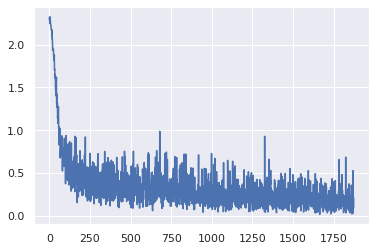

In [7]:
net = SimpleNet()

losses = train(net, data['train'])
plt.plot(losses)

##Testing The Network##

We trained our network! The loss went down! That's good, right? But how good is our network, exactly?

Well, we can try running our network on a few of our test images and see what happens:

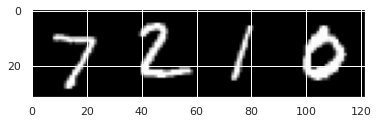

GroundTruth:      7     2     1     0
Predicted:      7     2     1     0


In [8]:
dataiter = iter(data['test'])
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % data['classes'][labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % data['classes'][predicted[j]]
                              for j in range(4)))

Pretty good so far. But we also want to be able to test the network on all of our data. Here's a function that can do just that, computing the accuracy on a full set of data:

In [9]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

Now we can give it a try:

In [10]:
print("Current accuracy: %f" % accuracy(net, data['train']))

Current accuracy: 0.949500


##Experiments##

Now it's time to poke around a little bit with our models. First I just want this utility function to do window smoothing of data for us. As you may have noticed, we are doing *stochastic* gradient descent, so our losses for each mini-batch can vary quite dramatically. If we smooth them out a little bit they will be easier to look at when we plot them.

In [11]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='same')

###Learning Rate###

Let's experiment around with the learning rate of our model. Changing the learning rate should affect how fast our model converges and how accurate it is. We can see the effect when we plot out the loss function over time for models with different learning rates:

0.9549 0.9438 0.8941


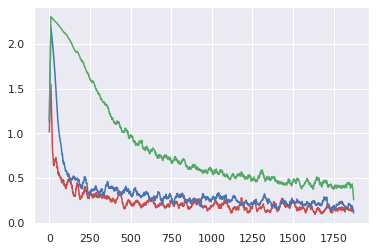

In [12]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

###Momentum###

We are using the default value for momentum of `0.9`. Fix your value for the learning rate and try varying the values for momentum.

####**Question 1: What affect does changing the value for momentum have on your model's convergence and final accuracy?**####

Since momentum is a hyperparameter between 0 and 1, I tried relatively large values (0.99), relatively small values (0.1), and in between (0.9). As shown in the graph below, it seems that higher values of momentum makes us converge faster. However, too high a momentum value seems to have a detrimental effect on our test accuracy.


####**Question 4.2 (from the README): Can you get >97% accuracy?**####

Yep--in our trymnist.py, we have hyperparameters set that will get us >97% accuracy on the test set!

####**Question 4.3 (from the README): How do your results compare to MNIST? If you changed your model for MNIST, do similar changes affect your CIFAR results in the same way?**####

The results from training CIFAR are much worse than training MNIST--we get around 40% accuracy. Even with tweaking the hyperparameters, what increased our test accuracy for MNIST relatively significantly did not lead to relatively significant accuracy improvements for CIFAR. We hypothesize that this is because classifying the CIFAR-10 dataset is a simply a much more complex problem than the MNIST dataset, and this is intuitively recognizable from a glance at the datasets themselves--CIFAR-10 images are much more complex and hard to recognize than MNIST's digits.

0.9559 0.9657 0.9139


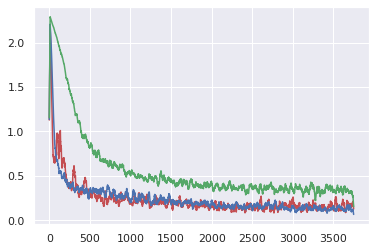

In [13]:
#TODO: Write your code here for experimenting with different values of momentum.
net_high = SimpleNet()
losses_high = train(net_high, data['train'], epochs=2, lr=.01, momentum=0.99, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], epochs=2, lr=.01, momentum=0.9, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], epochs=2, lr=.01, momentum=0.1, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

In [14]:
acc_train_mid = accuracy(net_high, data['train'])
print("Training accuracy: ", acc_train_mid)
print("Testing accuracy: ", acc_mid)

Training accuracy:  0.9632333333333334
Testing accuracy:  0.9657


###Weight Decay###

Right now we aren't using any weight decay with our model. However, it can be useful as a method of regularization if we are worried about overfitting.

Take your best performing model parameters from above for learning rate and momentum. Fix these parameters as you answer the following questions:

####**Question 2: Is our current model overfit or underfit to our training data? How can you tell?**####

Our current model is not really overfit or underfit to our training data. The accuracy of the model is very similar when evaluated on our training data and our testing data. The testing accuracy is actually higher than the training accuracy (but we can attribute that to "luck", since the training model will bias the network towards training data). Additionally, its accuracy is relatively decent, so it is likely not underfit.

####**Question 3: Try out some different values for weight decay. What effect do they have on model convergence? What about final accuracy? Does this match with what you would have expected? Why or why not?**####

Weight decay seems to not have much effect on the rate of model convergence, but it does seem to affect final accuracy. Weight decay a.k.a. regularization is used to penalize overfitting by adding a regularization term in the loss function, penalizing high-magnitude weight values, so clearly a large lambda will lead to higher model bias and lower model variance as we see for the red line below. Interestingly, we see that even with a lambda of 10^-4, our test accuracy seems to be higher than a model trained with a lambda of 10^-2. This is further evidence that our model is not substantially overfit since evidently we don't need large amounts of regularization. In fact, regularization is seemingly hurting our model's predictive performance.

0.8241 0.9251 0.9647


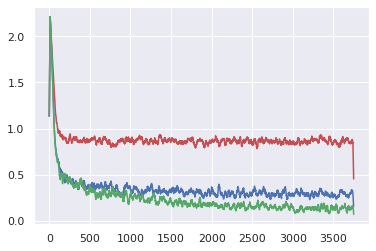

In [15]:
#TODO: Write your code here for experimenting with different weight decay
net_high = SimpleNet()
losses_high = train(net_high, data['train'], epochs=2, lr=.01, momentum=0.9, decay=0.1, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], epochs=2, lr=.01, momentum=0.9, decay=0.01, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], epochs=2, lr=.01, momentum=0.9, decay=0.0001, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

###A Bigger Model###

Before we used a very simple model but now it's time to try adding some complexity. Create a network that takes as input the 28x28 image, 10 outputs, and any number of layers as long as it has fewer than 2,000,000 connections. Our simple network before had 784\*512 + 512\*10 = 406,528 connections.

Use only fully connected (`nn.Linear`) layers (we'll get to other layer types soon). However, play around with different [activation functions](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions), [losses](https://pytorch.org/docs/stable/nn.html#loss-functions), and hyperparameter settings. You can also try different training regimes. For example, you could try lowering the learning rate during training by calling our training method twice like this:

    train(net, data['train'], epochs=5, lr=.1)
    train(net, data['train'], epochs=3, lr=.01)
    train(net, data['train'], epochs=2, lr=.001)

Maybe it works better? Why did I choose those particular numbers? Who knows! It's deep learning, no one really knows what will work you have to just try things and see.

Experiment with different network architectures and settings to get the most accurate model.

####**Question 4: Describe your final model architecture. How did you come up with the number of layers and number of neurons at each layer?**####

The final model architecture has an input layer, an output layer, and 3 hidden layers, with sizes 512, 256, and 128 from back to front. We've read online that the number of hidden neurons should usually be in between the size of the inputs and outputs connecting them, so we made the sizes of the hidden layer to be monotonically decreasing. To be frank, however, choosing the actual numbers and the number of hidden layers to have was pretty arbitrary. We also wanted to experiment with dropout since it apparently has some empirically observed performance gains but we stuck with simply fully connected layers in our final architecture.

We used Leaky ReLUs as our activation functions. Performance-wise, we didn't see too much of a difference between ReLUs and Leaky ReLUs, but we tended to stick to those to minimize the amount of time it took to train.

We did not experiment that much with different losses. Cross entropy seems to be the best loss function for multinomial classification, and it makes sense intuitively when looking at the softmax function.

####**Question 5: What hyperparameters did you experiment with? What values were good for them? Do you think your model was over or under fitting the data?**####

In particular, we chose to experiment most broadly with the regularization hyperparameter. Learning rate and momentum seem to be pretty stable but with a more complex network we knew that the chance that our model would overfit would be quite high, so we experimented with the lambda to see if we could penalize the overfitting tendencies with regularization and develop a more robust model. It turns out a lambda of 1e-5 was quite good for our model--we weren't actually overfitting that much--as you can see, our model is quite accurate on the test set, nearing 98% accuracy on 4 epochs (net_6).

We still did experiment with the learning rate, however. A learning rate of 0.001 seemed to converge a little too slowly, and 0.1 not as accurately as we'd like. A learning rate of 0.01 worked quite well.

Ultimately, I think our model performed quite well. I think we probably could've squeezed out a little bit more performance if we experimented training for more epochs and perhaps did a training regime such as the one above where we decrease the learning rate as we are closer to converging to get more "fine-tuning" accuracy gains, but those gains would definitely be in the realm of diminishing returns for experimentation. We did, however, train a "final" neural network, and it got pretty good (98.5% test accuracy). 

Also, our network was definitely overfitting, since our train accuracy was nearing 100%. But this isn't that bad in terms of practicality since this sort of overfitting is sort of expected--our model will obviously be biased towards the data on which it trains.

In [16]:
#TODO: Write your new model and experiments here

class ExperiNet(nn.Module):
    def __init__(self):
        super(ExperiNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        # self.dropout = nn.Dropout(p=0.5)
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x


0.9763 0.9752 0.9459


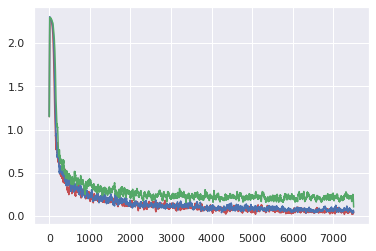

In [17]:
net_1 = ExperiNet()
losses_1 = train(net_1, data['train'], epochs=4, lr=.01, momentum=0.9, decay=0.0001, verbose=0)
acc_1 = accuracy(net_1, data['test'])
plt.plot(smooth(losses_1,20), 'r-')

net_2 = ExperiNet()
losses_2 = train(net_2, data['train'], epochs=4, lr=.01, momentum=0.9, decay=0.001, verbose=0)
acc_2 = accuracy(net_2, data['test'])
plt.plot(smooth(losses_2,20), 'b-')

net_3 = ExperiNet()
losses_3 = train(net_3, data['train'], epochs=4, lr=.01, momentum=0.9, decay=0.01, verbose=0)
acc_3 = accuracy(net_3, data['test'])
plt.plot(smooth(losses_3,20), 'g-')

print(acc_1, acc_2, acc_3)

0.9765 0.9754 0.9758


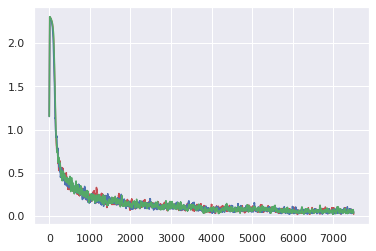

In [18]:
net_4 = ExperiNet()
losses_4 = train(net_4, data['train'], epochs=4, lr=.01, momentum=0.9, decay=0, verbose=0)
acc_4 = accuracy(net_4, data['test'])
plt.plot(smooth(losses_4,20), 'r-')

net_5 = ExperiNet()
losses_5 = train(net_5, data['train'], epochs=4, lr=.01, momentum=0.9, decay=0.000001, verbose=0)
acc_5 = accuracy(net_5, data['test'])
plt.plot(smooth(losses_5,20), 'b-')

net_6 = ExperiNet()
losses_6 = train(net_6, data['train'], epochs=4, lr=.01, momentum=0.9, decay=0.00001, verbose=0)
acc_6 = accuracy(net_6, data['test'])
plt.plot(smooth(losses_6,20), 'g-')

print(acc_4, acc_5, acc_6)

In [19]:
net_final = ExperiNet()
train(net_final, data['train'], epochs=5, lr=.01, momentum=0.9, decay=1e-5, verbose=0)
train(net_final, data['train'], epochs=7, lr=.001, momentum=0.9, decay=1e-5, verbose=0)
train(net_final, data['train'], epochs=10, lr=.0001, momentum=0.9, decay=1e-5, verbose=0)
acc_final = accuracy(net_final, data['test'])
acc_train_final = accuracy(net_final, data['train'])
print("Training accuracy: ", acc_train_final)
print("Testing accuracy: ", acc_final)

Training accuracy:  0.99925
Testing accuracy:  0.9838


##Download and submit!##

Download your iPythorn notebook from Colab to your `hw0` directory. Then follow the instructions to collate and submit your homework.